# Malicious traffic classifier using Multi-Class Logistic Regression

The script classifies packets into three classes: benign, cryptominer and bruteforce, as well as a custom implementation of a Logistic Regression Classifier.

A very good resource for understanding all the math behind the code: https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/

In [1]:
%load_ext autoreload
%autoreload 2

We already visualised and processed the data in `decision_tree/analysis.ipynb`. We'll get directly into the regression classifier.

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

# Hotfix to allow script to be run from anywhere
__import__('sys').path.append('..')

from preprocessing.utils import *
from preprocessing.visual_utils import *


traffic_data, labels = load_network_dataset()

DF_FIELDS = traffic_data.columns
IP_FIELDS = ['origin_ip', 'response_ip']

# split the ip fields into 4 columns
ip_transformer = ColumnTransformer(
    transformers=[
        ('ip_splitter', IPTransformer(IP_FIELDS), IP_FIELDS),
    ],
    remainder='passthrough'
)

updated_traffic_data = ip_transformer.fit_transform(traffic_data)
updated_traffic_data = pd.DataFrame(updated_traffic_data)

We can try to classify the data using the sci-kit learn library, but we'll implement the classifier from scratch to understand the math behind it.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(updated_traffic_data, labels, test_size=0.2, stratify=labels)

# Classify using Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=5000)
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

# Evaluate the model
lr_cmat = confusion_matrix(y_test, lr_predict)
report = classification_report(y_test, lr_predict)

print(report)

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00       150
  bruteforce       1.00      1.00      1.00        30
 cryptominer       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



It converges after about 1000 iterations, however lgbfs throws warnings about the convergence. We can try to increase the number of iterations, but it's not necessary for this dataset. We see that the accuracy is 0.99, which is very good.

# Custom Variant

Now we'll use the custom implementation of the classifier. We'll use the same dataset as before. It uses softmax regression to classify the data.
But now we need to take into consideration multiple things. First of all, we must normalize the data to make it easier for the classifier to converge. We'll use the StandardScaler from the sci-kit learn library to do this.

If we skip this step, the initial errors will be very high (because some fields values are way bigger than the others) and the classifier will not converge.

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import numpy as np

from logistic_regression import LogisticRegression


# Scale the data to avoid huge initial errors
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now, we must one-hot encode the labels. We'll use the LabelBinarizer from the sci-kit learn library to do this.

In [5]:
# One-hot encode the labels

y_train = np.array(y_train)
y_test = np.array(y_test)

encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

Finally, train the classifier and evaluate it.

In [7]:
# Classify using Custom Logistic Regression
epochs = 500
lr = LogisticRegression()
losses = lr.fit(X_train, y_train, learning_rate=0.01, epochs=epochs, batch_size=32, verbose=True)

lr_predict = lr.predict(X_test)
lr_predict = encoder.inverse_transform(lr_predict)

# Evaluate the model
lr_cmat = confusion_matrix(y_test, lr_predict)
report = classification_report(y_test, lr_predict, target_names=encoder.categories_[0])

print(report)

Loss at epoch 0: 1.1223719936578547
Loss at epoch 100: 0.2582461511306976
Loss at epoch 200: 0.166347669972319
Loss at epoch 300: 0.12355215569066144
Loss at epoch 400: 0.09881196719029144
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00       150
  bruteforce       1.00      1.00      1.00        30
 cryptominer       1.00      1.00      1.00        20

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



The accuracy is 1.00, which is the best we could expect. We can plot the loss function to see how it converges.

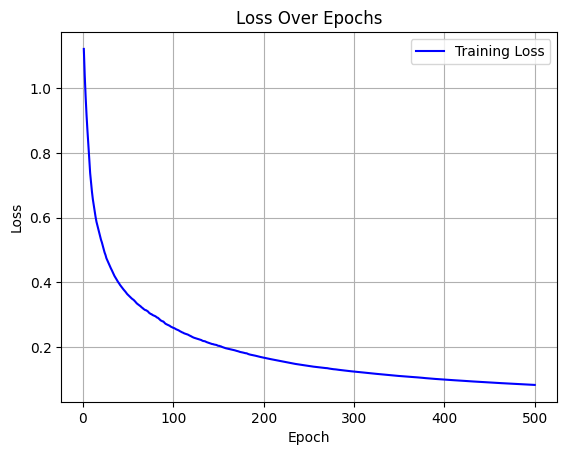

In [10]:
import matplotlib.pyplot as plt

# Plot the loss curve
plt.plot(range(1, epochs+1), losses, linestyle='-', color='b', label="Training Loss")

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.show()